In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

# Load the API key from the .env file
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

In [2]:
from typing import List, Literal, TypedDict

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableConfig
from langchain_openai import ChatOpenAI

from langgraph.graph import END, START, StateGraph

# Create an initial prompt
create_initial_prompt = """
"Create an initial prompt by Analyzing a comprehensive set of questions and answers that encapsulate the user's current self across various dimensions (such as cognitive patterns, emotional balance, developmental stages, belief systems, personal values, and growth ambitions). 

Context: {context}

Use this information to craft a personalized system prompt for an AI assistant. The goal of this system prompt is to enable the AI to:

The system prompt should include a detailed summary of the user’s key traits, priorities, and values, as well as any stated challenges or opportunities for growth. It should enable the AI to integrate this understanding into every response, ensuring a highly personalized and user-centric form of assistance."
"""

summarize_prompt = ChatPromptTemplate([("human", create_initial_prompt)])

llm = ChatOpenAI(model="gpt-4o")

initial_summary_chain = summarize_prompt | llm | StrOutputParser()

# Refining the summary with new docs
refine_template = """
Produce a final prompt.

Existing summary up to this point:
{existing_answer}

New context:
------------
{context}
------------

Given the new context, refine the original prompt.
"""
refine_prompt = ChatPromptTemplate([("human", refine_template)])

refine_summary_chain = refine_prompt | llm | StrOutputParser()


# We will define the state of the graph to hold the document
# contents and summary. We also include an index to keep track
# of our position in the sequence of documents.
class State(TypedDict):
    contents: List[str]
    index: int
    summary: str


# We define functions for each node, including a node that generates
# the initial summary:
async def generate_initial_summary(state: State, config: RunnableConfig):
    summary = await initial_summary_chain.ainvoke(
        state["contents"][0],
        config,
    )
    return {"summary": summary, "index": 1}


# And a node that refines the summary based on the next document
async def refine_summary(state: State, config: RunnableConfig):
    content = state["contents"][state["index"]]
    summary = await refine_summary_chain.ainvoke(
        {"existing_answer": state["summary"], "context": content},
        config,
    )

    return {"summary": summary, "index": state["index"] + 1}


# Here we implement logic to either exit the application or refine
# the summary.
def should_refine(state: State) -> Literal["refine_summary", END]:
    if state["index"] >= len(state["contents"]):
        return END
    else:
        return "refine_summary"


graph = StateGraph(State)
graph.add_node("generate_initial_summary", generate_initial_summary)
graph.add_node("refine_summary", refine_summary)

graph.add_edge(START, "generate_initial_summary")
graph.add_conditional_edges("generate_initial_summary", should_refine)
graph.add_conditional_edges("refine_summary", should_refine)
app = graph.compile()

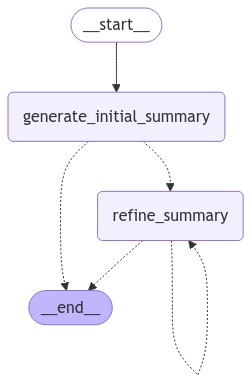

In [3]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

In [ ]:
from langchain_community.document_loaders.csv_loader import CSVLoader
from langgraph.constants import Send

# Load the CSV file containing question-answer pairs
file_path = "data/questions_with_answers.csv"
loader = CSVLoader(
    file_path=file_path,
    csv_args={
        "delimiter": ",",
        "quotechar": '"',
        "fieldnames": ["Category", "Goal", "Element", "Question_1", "Answer_1", "Question_2", "Answer_2", "Question_3", "Answer_3"],
    },
)
data = loader.load()

async for step in app.astream(
    {"contents": [doc.page_content for doc in data]},
    stream_mode="values",
):
    if summary := step.get("summary"):
        print(summary)